<a href="https://colab.research.google.com/github/ncsu-landscape-dynamics/LAMP_assay_automation/blob/main/imagecolorsegmentationwithopencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
import imageio
import scipy.misc
import skimage.filters
import skimage.metrics
from PIL import Image
import pandas as pd

These are notes from a conversation with Rajesh:

The phone takes a picture just from the camera, no other apps or interfaces are required. 

Take two pics. One at 1 minute, start of process, and other after 60 minutes. 

The pics are .dng format. This is a kind of RAW developed by Adobe. 

Convert the pics to tiff. 

Split to RGB bands. Keep green. 

IMAGEJ > select a band in the chamber > ctl+M > look at mean of florescent intensity. 

Repeat with 2nd image and compare via normalized intensity calculation : [intensity_60 – intensity_1] / intensity_1

Plot results. 

Use threshold to determine infection by pathogen. Normalized intensity > threshold = positive (infected).

The phone only takes a picture of the chamber, gets time, and location. Since there is no interface, there are no other data associated with pictures of the chambers.

There are screenshots from video chat with Rajesh available in this [doc](https://docs.google.com/document/d/19B4bBSOuLnx1Ng7tTzfXAfurfzruMAR_1RGgikR_CSA/edit)

In [ ]:
!pip install rawpy

     |████████████████████████████████| 1.7MB 8.2MB/s 


In [ ]:
import rawpy


In [ ]:
#This was used just for some information in initial testing. Not necessary to use this furth.
!pip install ExifRead

In [ ]:
import exifread

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
plate = rawpy.imread('/content/drive/MyDrive/Colab Notebooks/Copy of 0724201706a.dng')

In [ ]:
#skip next two lines
plate_x = open('/content/drive/MyDrive/Colab Notebooks/Copy of 0724201706a.dng', 'rb')

In [ ]:
plate_tags = exifread.process_file(plate_x)
plate_tags

{'EXIF DateTimeOriginal': (0x9003) ASCII=2020:07:24 17:06:18 @ 1678,
 'EXIF ExifVersion': (0x9000) Undefined=0221 @ 636,
 'EXIF ExposureProgram': (0x8822) Short=Unidentified @ 612,
 'EXIF ExposureTime': (0x829A) Ratio=1/2 @ 1662,
 'EXIF FNumber': (0x829D) Ratio=9/5 @ 1670,
 'EXIF Flash': (0x9209) Short=Flash did not fire @ 672,
 'EXIF FocalLength': (0x920A) Ratio=221/50 @ 1698,
 'EXIF ISOSpeedRatings': (0x8827) Short=50 @ 624,
 'EXIF MeteringMode': (0x9207) Short=CenterWeightedAverage @ 660,
 'Image Artist': (0x013B) ASCII= @ 946,
 'Image BitsPerSample': (0x0102) Short=10 @ 54,
 'Image BlackLevel': (0xC61A) Long=[0, 0, 0, 0] @ 1106,
 'Image CFAPattern': (0x828E) Byte=[0, 1, 1, 2] @ 270,
 'Image CFARepeatPatternDim': (0x828D) Short=[2, 2] @ 258,
 'Image Compression': (0x0103) Short=Uncompressed @ 66,
 'Image Copyright': (0x8298) ASCII= @ 1010,
 'Image DateTime': (0x0132) ASCII=2020:07:24 17:06:18 @ 926,
 'Image ExifOffset': (0x8769) Long=578 @ 294,
 'Image ImageDescription': (0x010E) AS

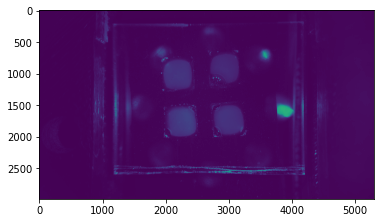

In [ ]:
plt.imshow(plate.raw_image)

In [ ]:
plate

Text(0.5, 1.0, 'Raw histogram')

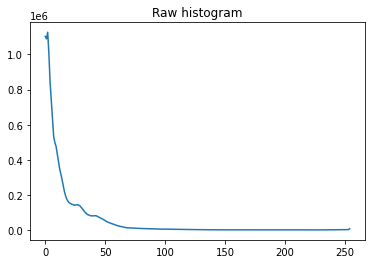

In [ ]:
counts, vals = np.histogram(plate.raw_image, bins=range(2**8))
plt.plot(range(0, (2**8)-1), counts)
plt.title("Raw histogram")

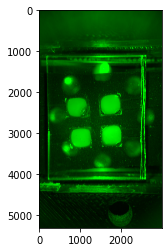

In [ ]:
plate_rgb = plate.postprocess( use_camera_wb=True)

plt.imshow(plate_rgb)

In [ ]:


# Show what we've got
print(f'Dimensions: {plate_rgb.shape}, dtype: {plate_rgb.dtype}')
R = plate_rgb[...,0]
print(f'R channel: min={R.min()}, mean={R.mean()}, max={R.max()}')
G = plate_rgb[...,1]
print(f'G channel: min={G.min()}, mean={G.mean()}, max={G.max()}')
B = plate_rgb[...,2]
print(f'B channel: min={B.min()}, mean={B.mean()}, max={B.max()}')


Dimensions: (5312, 2988, 3), dtype: uint8
R channel: min=0, mean=0.008399688109869196, max=255
G channel: min=0, mean=68.88454987117143, max=255
B channel: min=0, mean=0.11084404132594636, max=255


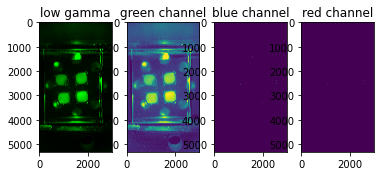

In [ ]:
plate_rgb_lo_gamma = plate.postprocess(gamma=(1,1))

plt.subplot(1,4,1)
plt.imshow(plate_rgb_lo_gamma)  #terse explanation: gamma controls brightness
plt.title("low gamma")
plt.subplot(1,4,2)
plt.imshow(plate_rgb[:,:,1]) #this is the "green" channel
plt.title("green channel")
plt.subplot(1,4,3)
plt.imshow(plate_rgb[:,:,2])
plt.title("blue channel")
plt.subplot(1,4,4)
plt.imshow(plate_rgb[:,:,0])
plt.title("red channel")
plt.show()


In [ ]:
# In the image above, if the chambers are numbered clockwise from bottom left, 
# number 2 (upper left) is the assay for Phytophthora infestans. 

In [ ]:
imageio.imsave('/content/drive/MyDrive/Colab Notebooks/images/green1.tif', plate_rgb[:,:,1])
imageio.imsave('/content/drive/MyDrive/Colab Notebooks/images/normal.tif', plate_rgb)

In [ ]:
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm
from matplotlib import colors

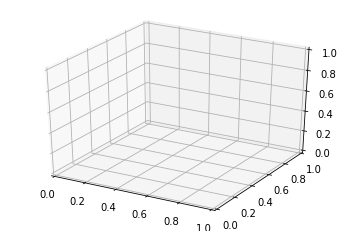

In [ ]:
r, g, b = cv2.split(plate_rgb)
fig = plt.figure()
axis = fig.add_subplot(1,1,1, projection="3d")

In [ ]:
b.flatten()

array([11,  6,  8, ..., 33,  9,  0], dtype=uint8)

In [ ]:
pixel_colors = plate_rgb.reshape((np.shape(plate_rgb)[0]*np.shape(plate_rgb)[1],3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

In [ ]:
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors = pixel_colors, marker = ".")
axis.set_xlabel('Red')
axis.set_ylabel('Green')
axis.set_zlabel('Blue')
plt.show()

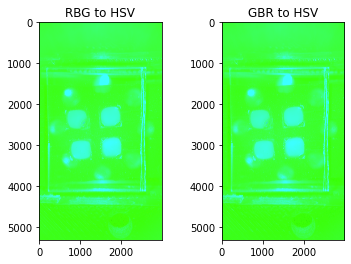

In [ ]:
plateRGB_hsv = cv2.cvtColor(plate_rgb, cv2.COLOR_RGB2HSV)
plate_hsv = cv2.cvtColor(plate_rgb, cv2.COLOR_BGR2HSV)

plt.subplot(1,2,1)
plt.imshow(plateRGB_hsv)
plt.title("RBG to HSV")
plt.subplot(1,2,2)
plt.imshow(plate_hsv)
plt.title("GBR to HSV")
plt.show()


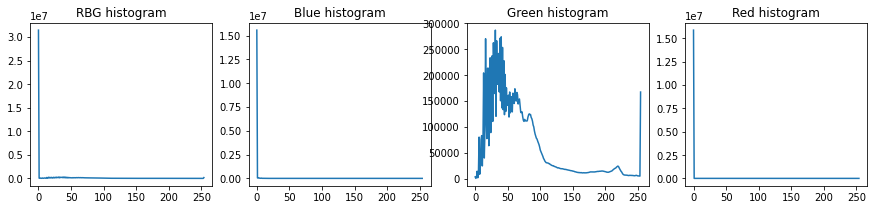

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(3)
plt.subplot(1,4,1)
counts, vals = np.histogram(plate_rgb, bins=range(2**8))
plt.plot(range(0, (2**8)-1), counts)
plt.title("RBG histogram")
plt.subplot(1,4,2)
countsb, valsb = np.histogram(plate_rgb[:,:,2], bins=range(2**8))
plt.plot(range(0, (2**8)-1), countsb)
plt.title("Blue histogram")
plt.subplot(1,4,3)
countsg, valsg = np.histogram(plate_rgb[:,:,1], bins=range(2**8))
plt.plot(range(0, (2**8)-1), countsg)
plt.title("Green histogram")
plt.subplot(1,4,4)
countsr, valsr = np.histogram(plate_rgb[:,:,0], bins=range(2**8))
plt.plot(range(0, (2**8)-1), countsr)
plt.title("Red histogram")

plt.show()


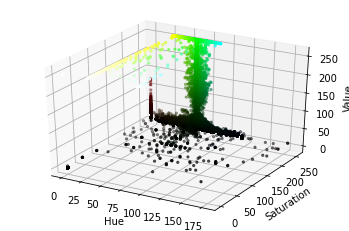

In [ ]:
h,s,v = cv2.split(plate_hsv)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolor=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [ ]:
q_1 = plate_rgb[2950:3200, 900:1200, :].copy()
q_2 = plate_rgb[2250:2500, 700:1050, :].copy()
q_3 = plate_rgb[2100:2500, 1500:2000, :].copy()
q_4 = plate_rgb[2900:3300, 1500:2000, :].copy()

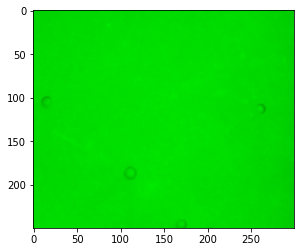

In [ ]:
plt.imshow(q_1)

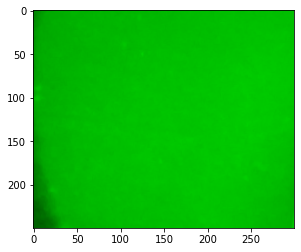

In [ ]:
plt.imshow(q_2)

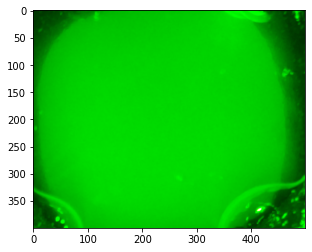

In [ ]:
plt.imshow(q_3)

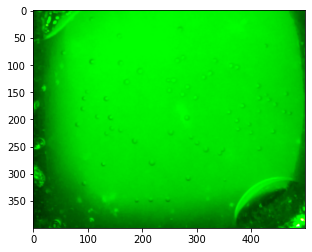

In [ ]:
plt.imshow(q_4)

In [ ]:
q_4.shape

(400, 500, 3)

In [ ]:
# Get a color to use as threshold. 
# Tried several combinations to get this for starters.
# Lower threshold.
hsv_green_lo = (59, 100, 135) #h = 50, s = 250, v = 150)

from matplotlib.colors import hsv_to_rgb

#gn_sq = np.full((10, 10, 3), hsv_green_lo, dtype=np.uint8)/255

#plt.imshow(hsv_to_rgb(gn_sq))
#plt.show()

In [ ]:
hsv_green_lo

(59, 100, 135)

In [ ]:
# Get a color to use as threshold. 
# Tried several combinations to get this for starters.
# Upper threshold.
hsv_green_hi = (75, 250, 255) #h = 50, s = 250,f v = 150)

from matplotlib.colors import hsv_to_rgb

#gn_sq = np.full((10, 10, 3), hsv_green_hi, dtype=np.uint8)/255

#plt.imshow(hsv_to_rgb(gn_sq))
#plt.show()

In [ ]:
plateRGB_hsv.shape

(5312, 2988, 3)

In [ ]:
green_thr = cv2.inRange(plateRGB_hsv, hsv_green_lo, hsv_green_hi)

img_msk = cv2.bitwise_and(plateRGB_hsv, plateRGB_hsv, green_thr)

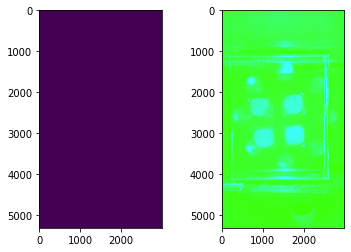

In [ ]:
plt.subplot(1,2,1)
plt.imshow(green_thr)
plt.subplot(1,2,2)
plt.imshow(img_msk)
plt.show()

In [ ]:
plate_hsv[:,:,2]

array([[52, 55, 54, ..., 59, 59, 37],
       [55, 58, 54, ..., 60, 48,  9],
       [54, 54, 51, ..., 55, 55, 24],
       ...,
       [27, 27, 27, ..., 38, 32,  9],
       [30, 28, 28, ..., 38, 39, 15],
       [28, 27, 26, ..., 38, 28,  9]], dtype=uint8)

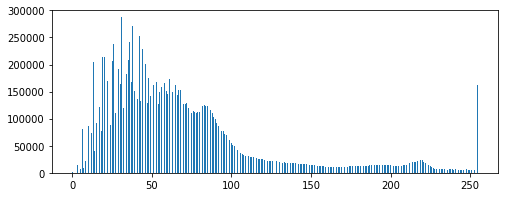

In [ ]:
plat_val = plate_hsv[:,:,2]
fig, (ax0) = plt.subplots( figsize=(8, 3))
ax0.hist(plat_val.ravel(), 512)
plt.show()

In [ ]:
rgb_out = cv2.bitwise_and(plate_rgb, plate_rgb, green_thr)

[]

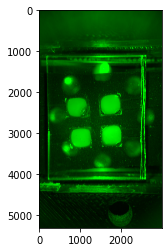

In [ ]:
plt.imshow(rgb_out)
plt.plot()

In [ ]:
green_c = plate_rgb[...,1]

In [ ]:
green_c_describ = pd.DataFrame(green_c)
green_c_describ.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987
count,5312.000000,5312.000000,5312.00000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,...,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000,5312.000000
mean,39.449736,39.326431,39.43317,39.625565,39.727974,39.684111,39.596950,39.355798,39.391943,39.168298,39.119917,39.090550,39.149849,39.108057,39.220821,39.060053,39.188630,39.072477,39.083773,38.973645,39.012801,39.066830,39.183923,39.260166,39.291792,39.276544,39.263178,39.241905,39.397402,39.294992,39.521649,39.531815,39.715173,39.814759,39.899096,40.044239,40.102221,40.052146,40.356363,40.296687,...,39.624435,39.517884,39.407380,39.387425,39.424699,39.382718,39.562312,39.509413,39.437688,39.323795,39.281250,38.997929,39.226468,39.293675,39.378765,39.479104,39.565512,39.584526,39.652108,39.652673,39.873306,39.983810,40.013178,39.967809,39.860316,39.800075,39.844127,39.842432,39.833396,39.723833,39.908886,40.150602,40.101468,39.986446,40.126506,40.086220,39.918486,40.091679,36.361446,7.807229
std,21.065680,21.121520,21.00802,20.957805,20.760843,20.796555,20.603382,20.567204,20.378743,20.493128,20.294214,20.252201,20.042925,20.084082,19.862377,19.950106,19.886872,19.975032,19.926686,20.051658,20.053877,20.146981,20.115058,20.270745,20.133838,20.313207,20.322527,20.515445,20.536075,20.813301,20.850074,21.055685,21.144053,21.380908,21.496392,21.741132,21.774972,21.913820,21.826331,22.006137,...,15.354309,15.342388,15.210482,15.213838,14.940098,14.916077,14.729171,14.608463,14.546683,14.558507,14.332167,14.394573,14.252349,14.325163,14.288577,14.310841,14.165185,14.205608,14.099167,14.223756,14.178275,14.268049,14.198296,14.313589,14.343044,14.467773,14.472387,14.728108,14.757754,15.069948,15.309632,15.696540,15.915058,16.181336,16.316195,16.480022,16.560927,16.708519,16.434427,10.210573
min,5.000000,6.000000,4.00000,6.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,6.000000,6.000000,6.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,9.000000,10.000000,10.000000,10.000000,9.000000,6.000000,6.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,8.000000,10.000000,10.000000,13.000000,8.000000,10.000000,9.000000,9.000000,10.000000,10.000000,10.000000,12.000000,10.000000,10.000000,13.000000,12.000000,10.000000,12.000000,10.000000,12.000000,12.000000,9.000000,9.000000,10.000000,10.000000,13.000000,13.000000,9.000000,12.000000,9.000000,12.000000,7.000000,7.000000,8.000000,0.000000
25%,26.000000,26.000000,26.00000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,25.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000

In [ ]:
green_thr = cv2.inRange(green_c, 20, 80)

img_msk = cv2.bitwise_and(green_c, green_c, green_thr)

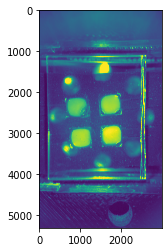

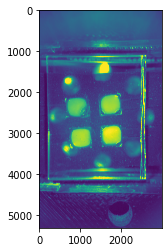

In [ ]:
plt.subplot(1,2,1)
plt.imshow(green_thr)
plt.show()
plt.subplot(1,2,2)
plt.imshow(img_msk)
plt.show()

In [ ]:
new_gr = green_c.copy()

In [ ]:
#see about subsituting values in new_gr with black

new_gr[new_gr > 101] = 0
new_gr[new_gr < 30] = 0

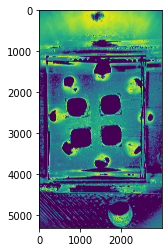

In [ ]:
plt.imshow(new_gr)
plt.show()

In [ ]:
new_gr[new_gr < 101] = 0
#new_gr[new_gr < 30] = 0

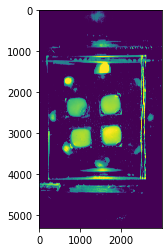

In [ ]:
plt.imshow(new_gr)
plt.show()
green_c = plate_rgb[...,1]

The following code is a filter or mask. This is applied to the green channel. 

In [ ]:
new_gr[new_gr < 150] = 0
new_gr[new_gr > 230] = 0

The following image is a masked image. The mask removes noise. Obviously, there are still other chambers that need to be accounted for, while the top left chamber is the chamber of interest for blight. 

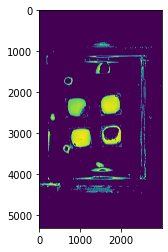

In [ ]:
# This image is a masked image.
plt.imshow(new_gr)
plt.show()
new_gr = green_c.copy()

In [ ]:
greenfilename = "updated_image.tif"
cv2.imwrite(greenfilename, new_gr)

True

In [ ]:
# The following is from the PyTorchImSeg notebook:
#Visualizing the raw image doesn't seem too helpful. The image can be postprocessed,
#but I am unsure if there are undesirable effects of that. 
#However, as long as the same process is applied to each image, that equalizes
#some of the side effects.
#This Stackoverflow Q&A has some information to consider related to the topic.
#https://stackoverflow.com/questions/49459630/rawpy-how-to-postprocess-raw-images-without-adulterating-pixel-data
#image.postprocess(gamma=(1,1), no_auto_bright=True, output_bps=16)

#This is the way I've used it so far:
postpro_list = []
for image in image_list: 
    postpro_list.append(image.postprocess(use_camera_wb=True))